In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from saif.crs_model.peakdetector import pk_indxs
import saif.scinet.model as scinet
# plt.style.use('ggplot')

%matplotlib inline

In [2]:
# from saif.scinet.dataset import daily_seismic_and_interpolated_pressure
# from saif.scinet.dataset import construct_time_series_dataset

from dataset import daily_seismic_and_interpolated_pressure
from dataset import construct_time_series_dataset
from dataset import overlap_and_interpolate
from dataset import aggregate_seismic

from torch.utils.data import DataLoader

In [4]:
import pandas as pd


seismic = pd.read_csv("../../../dataset_preparing/Temporal_Datasets/kansas/loc1/seismic.csv",index_col=None)
pressure = pd.read_csv("../../../dataset_preparing/Temporal_Datasets/kansas/loc1/pressure.csv",index_col=None)




In [5]:
import wandb

In [7]:
features, target_vals = daily_seismic_and_interpolated_pressure(seismic, pressure)


In [8]:
# input_len = 16 # try wider window power of 2
# horizon = 7 # prediction window

# Trying out different input_len and horizon
input_len = 16
horizon = 7

In [9]:
features = features[['pressure','dpdt','seismic']]

In [10]:
features = features[:-1]
target_vals = target_vals[:-1]

Visualization of the train / test split

Text(0, 0.5, 'normalized cumulative counts')

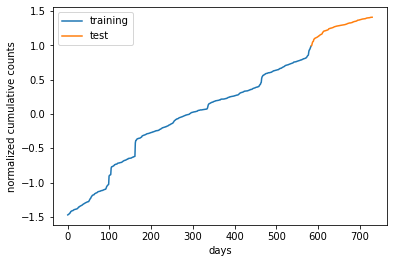

In [11]:
train_dset, test_dset, x_scaler, y_scaler = construct_time_series_dataset(
    features, target_vals, 
    input_len, horizon, features.columns, 
    # train_test_split=0.8, normalize_data=True # try train_test_split=0.75
    train_test_split=0.8, normalize_data=True
)

plt.figure()
plt.plot(np.arange(len(train_dset.Y)), train_dset.Y, label='training')
plt.plot(np.arange(len(test_dset.Y)) + len(train_dset.Y), test_dset.Y, label='test')
plt.legend()
plt.xlabel('days')
plt.ylabel('normalized cumulative counts')

### Model Architecture

In [12]:
class SimpleSCINet(nn.Module):
    def __init__(
        self, 
        input_len, output_len,
        input_dim, num_levels, kernel_size, dropout, groups, hidden_size
    ):
        super().__init__()
        
        self.input_len = input_len
        self.output_len = output_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.groups = groups
        self.kernel_size = kernel_size
        self.dropout = dropout
        
        self.bn1 = nn.BatchNorm1d(self.input_dim)
        self.bn2 = nn.BatchNorm1d(self.input_dim)
        
        self.block1 = scinet.EncoderTree(
            in_planes=self.input_dim,
            num_levels=self.num_levels,
            kernel_size=self.kernel_size,
            dropout=self.dropout,
            groups=self.groups,
            hidden_size=self.hidden_size,
            INN=True
        )
        
        # I'm a bit iffy on using a projector like this across features
        # But this is what they do in scinet
        # It should be fine, kernel size is 1, it's essentially just an
        # aggregation operation
        self.time_projector = nn.Conv1d(
            self.input_len, self.output_len,
            kernel_size=1, stride=1, bias=False
        )
        
        self.channel_projector = nn.Conv1d(
            self.input_dim, 1, kernel_size=1, stride=1, bias=True
        )
    
    def forward(self, x):
        out = x.permute(0, 2, 1)
        out = self.bn1(out)
        out = out.permute(0, 2, 1)
        
        out = self.block1(out)
        out += out
        
        out = F.relu(out)
        out = self.time_projector(out)
        
        out = out.permute(0, 2, 1)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.channel_projector(out).squeeze(1)
        
        #Enforcing monotonicity
        #out = torch.exp(out)
        #out = F.relu(out)
        # Exp has numerical issues, and relu was collapsing.
        # Squaring is also a positive operation
        out = out ** 2
        #out = torch.sigmoid(out)
        out = out.cumsum(-1) + x[:, -1, -1, None]
        
        return out

### Hyperparameters

In [16]:
input_dim = train_dset.X.shape[1]
num_levels = 3 # number of levels in the scinet tree
kernel_size = 2 # kernel size for the conv1D operations
dropout = 0.5 # dropout regularization params
groups = 1 # number of groups in the conv1D operation
hidden_size = 3 # scaling factor for the hidden dimension

lr = 1e-3 # learning rate
# n_epoch = 64 # number of epochs
n_epoch = 64

# Choose your loss function!/
# criterion = nn.MSELoss() # L2 loss
criterion = nn.HuberLoss() #An alternative, smoother version of the L1 Loss
# Less sensitive to outliers, less prone to exploding gradients

### Run Training

In [17]:

from tqdm.notebook import tqdm

In [18]:
test_loader = DataLoader(
    test_dset,
    batch_size=32 ,
    shuffle=False,
    num_workers=1
)
len(test_loader)

4

## Trying out sweep

In [22]:
config_defaults = {
        'input_dim': train_dset.X.shape[1],
        'num_levels' : 3, # number of levels in the scinet tree
        'kernel_size' : 2, # kernel size for the conv1D operations
        'dropout' : 0.5, # dropout regularization params
        'groups' : 1, # number of groups in the conv1D operation
        'hidden_size' :3, # scaling factor for the hidden dimension
        'lr' : 1e-3, # learning rate
        'n_epoch' : 64,
        'criterion': nn.HuberLoss()
}
criterion = nn.HuberLoss() #An alternative, smoother version of the L1 Loss

In [23]:
config_defaults['num_levels']

3

In [24]:
wandb.init(config=config_defaults)
config = wandb.config

wandb: Currently logged in as: alexandrechen. Use `wandb login --relogin` to force relogin


In [25]:
config.kernel_size

2

In [28]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'dropout': {
          'values': [0.5, 0.6, 0.7, 0.8]
        },
        'num_levels': {
          'values': [2,3,4]
        },
        'kernel_size': {
          'values': [2,3,4]
        },
        'hidden_size': {
          'values': [2,3,4]
        }
    }
        
}
sweep_id = wandb.sweep(sweep_config, entity="alexandrechen", project="test_scinet")

Create sweep with ID: nnmpxk8v
Sweep URL: https://wandb.ai/alexandrechen/test_scinet/sweeps/nnmpxk8v


In [29]:
def train():
    config_defaults = {
        'input_dim': train_dset.X.shape[1],
        'num_levels' : 3, # number of levels in the scinet tree
        'kernel_size' : 2, # kernel size for the conv1D operations
        'dropout' : 0.5, # dropout regularization params
        'groups' : 1, # number of groups in the conv1D operation
        'hidden_size' :3, # scaling factor for the hidden dimension
        'lr' : 1e-3, # learning rate
        'n_epoch' : 64,
        'criterion': nn.HuberLoss()
    }
    criterion = nn.HuberLoss() #An alternative, smoother version of the L1 Loss

    wandb.init(config=config_defaults)
    input_dim = config.input_dim
    num_levels = config.num_levels
    kernel_size = config.kernel_size
    dropout = config.dropout
    groups = config.groups
    hidden_size = config.hidden_size
    lr = config.lr
    n_epoch = config.n_epoch

    train_loader = DataLoader(
    train_dset,
    batch_size=32, # change batch size
    shuffle=True,
    num_workers=1
    )


    test_loader = DataLoader(
        test_dset,
        batch_size=32,
        shuffle=False,
        num_workers=1
    )

    model = SimpleSCINet(
        input_len, horizon,
        input_dim, num_levels, kernel_size, 
        dropout, groups, hidden_size
    )

    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_vals = []
    test_loss_vals = []


    for epoch in tqdm(range(n_epoch)):
        #train loop
        model.train()
        batch_loss_vals = []
        for (batch_x, batch_y) in train_loader:
            optimizer.zero_grad()
        
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
            batch_loss_vals.append(loss.item())
        train_loss_vals.append(np.mean(batch_loss_vals))
    
        #eval loop
        model.eval()
        batch_loss_vals = []
        for (batch_x, batch_y) in test_loader:        
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            batch_loss_vals.append(loss.item())
            metrics = {"train/train_loss": train_loss_vals[-1],
            "train/epoch": epoch,
            }
            wandb.log(metrics)
        test_loss_vals.append(np.mean(batch_loss_vals))
        print(epoch,train_loss_vals[-1],test_loss_vals[-1])
    
        val_metrics = {"test/test_loss":test_loss_vals[-1]}
        wandb.log(val_metrics)
    wandb.finish()
    
wandb.agent(sweep_id, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: h8iq72oq with config:
wandb: 	dropout: 0.8
wandb: 	hidden_size: 4
wandb: 	kernel_size: 2
wandb: 	num_levels: 2


  0%|          | 0/64 [00:00<?, ?it/s]

0 0.2520462932686011 12.842640042304993
1 0.061685884112699166 1.597850888967514
2 0.024424541586389143 0.38258652621880174
3 0.011145195070033273 0.21185422874987125
4 0.00979787695945965 0.14464234467595816
5 0.0063750780472118 0.08820840460248291
6 0.00624702491849247 0.04489064181689173
7 0.004230622784234583 0.03149692504666746
8 0.0043836967346982825 0.0375685136532411
9 0.0035306517966091633 0.03274530282942578
10 0.0026159242131850785 0.03465393197257072
11 0.002540257630041904 0.023859099193941802
12 0.002672906699849086 0.0191499880165793
13 0.00228680148979442 0.014712960051838309
14 0.002100010538318505 0.009369190811412409
15 0.0019892867163030636 0.006620443222345784


Visualize the forecast